# Corporate account image extraction

In [1]:
import pandas as pd
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pytesseract
import time
import shutil

In [2]:
base_path = 'Images/Corporate/'
corporate_imgs = os.listdir(base_path)

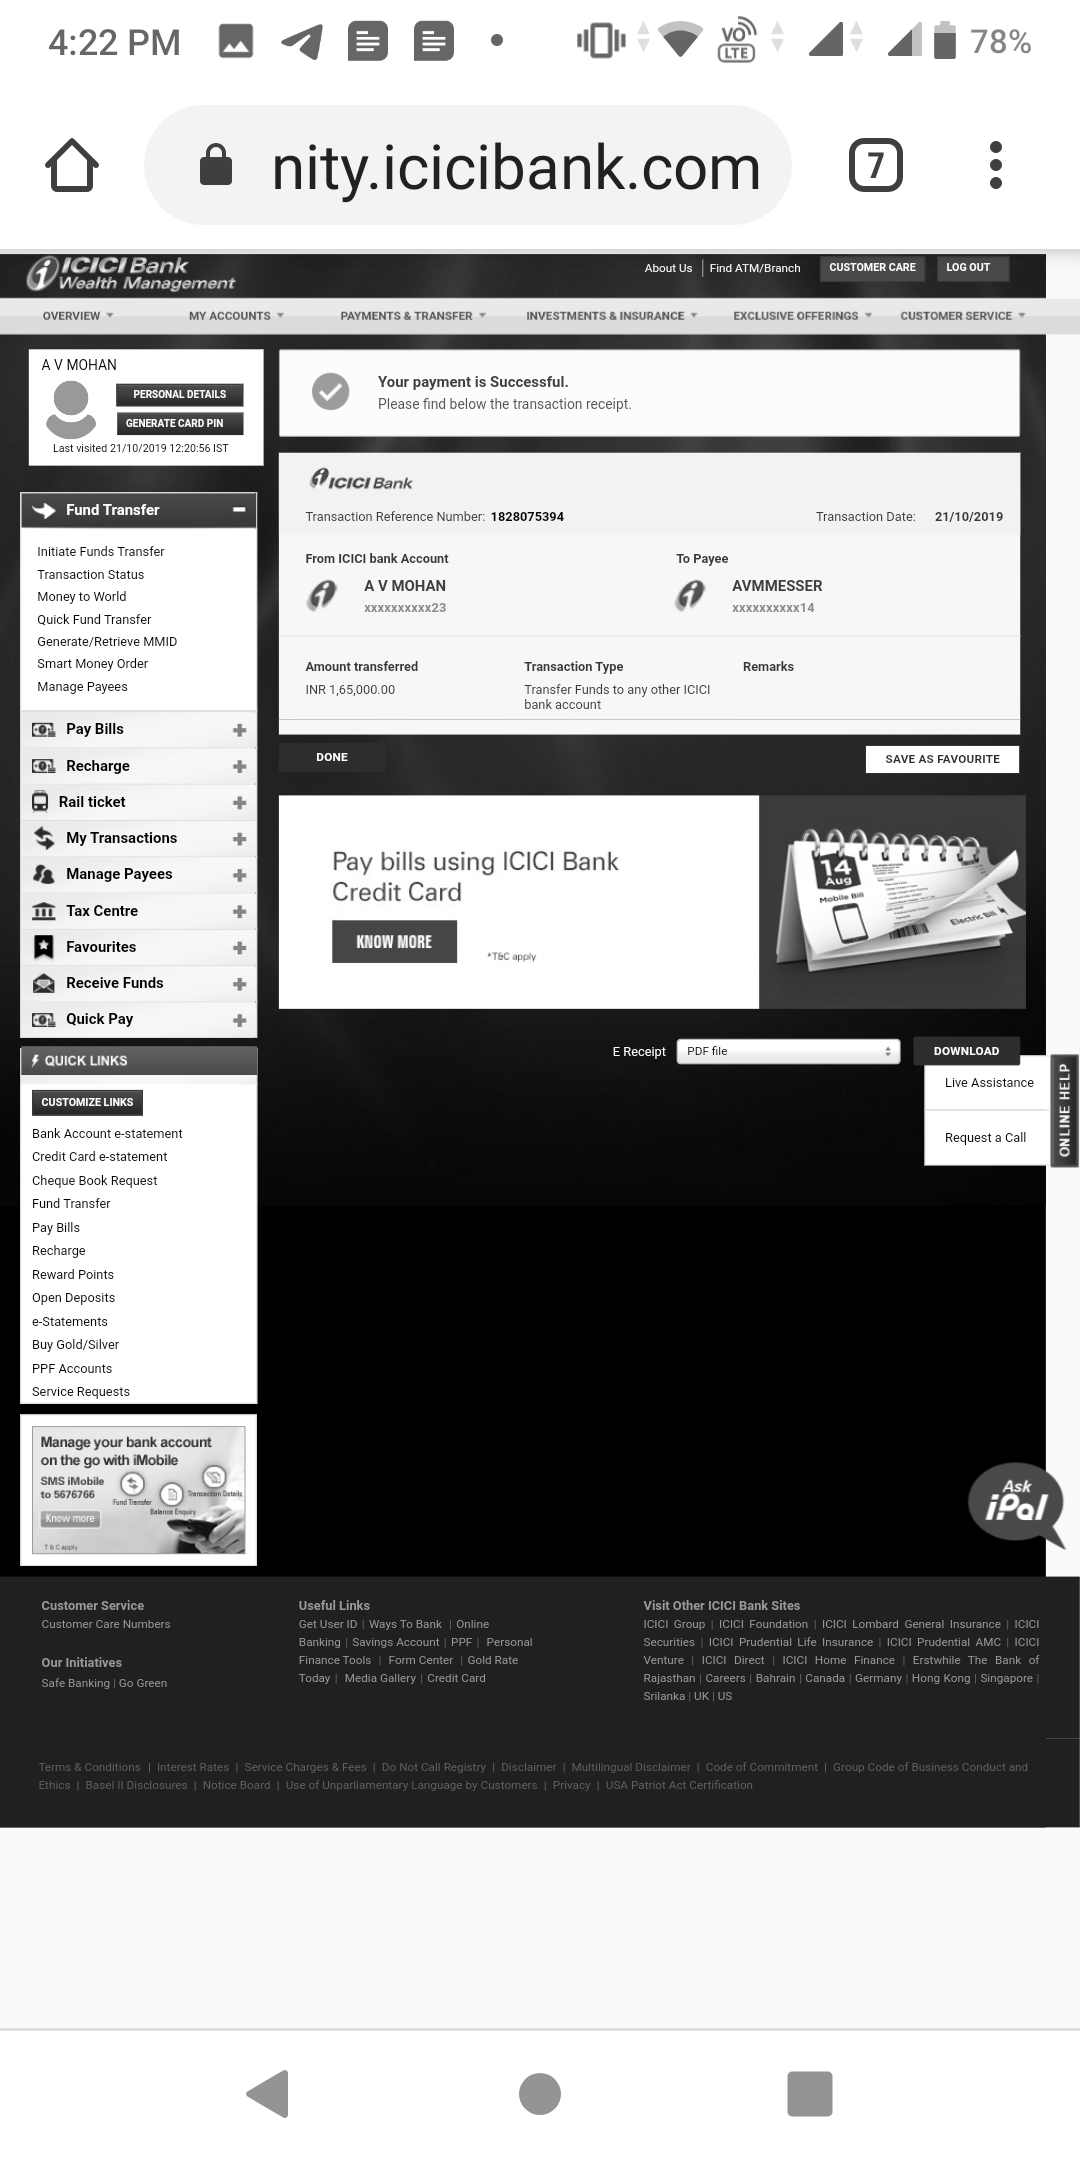

In [3]:
def read_img(base_path,corporate_imgs):
    img = cv2.imread(base_path+corporate_imgs)
    img_bw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img_bw
img_bw = read_img(base_path,corporate_imgs[3])
Image.fromarray(img_bw)

In [4]:
def find_outer_box(img_bw):
    ret, thresh = cv2.threshold(img_bw, 200, 255, cv2.THRESH_OTSU)
    canny = cv2.Canny(thresh,250,255)
    cnts,_ = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    cnt_areas = np.array([cv2.contourArea(cnts[i]) for i in range(len(cnts))])
    max_area_region = np.where(cnt_areas == max(cnt_areas))
    #Draw rectangle and crop largest area box in image
    x,y,w,h = cv2.boundingRect(cnts[max_area_region[0][0]])
    ROI = img_bw[y:y+h, x:x+w]
    #ROI = cv2.threshold(ROI,100,255, cv2.THRESH_OTSU)[1]
    extracted_img = Image.fromarray(ROI)
    return x,y,w,h,extracted_img

In [5]:
x,y,w,h,ROI = find_outer_box(img_bw)

In [6]:
def extract_all_text(img):
    return pytesseract.image_to_string(img)
    

In [7]:
extracted_text = extract_all_text(ROI)
extracted_text

' \n\n \n\nAicict Bank\n\nTransaction Reference Number: 1828075394 Transaction Date: 21/10/2019\nFrom ICICI bank Account To Payee\na AV MOHAN a AVMMESSER\n20000000023 99000000014\n‘Amount transferred Transaction Type Remarks\nINR 165,000.00 ‘Transfer Funds to any other ICICI\n\nbank account\n\n \n\x0c'

In [8]:
#Function that would dilate image and morph and find contours
def find_contours(img):
    k_dil = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(15,6))
    dilation1 = cv2.dilate(cv2.bitwise_not(img),kernel = k_dil,iterations =1)
    #plt.imshow(dilation1)
    mask = np.zeros_like(dilation1)
    mask[dilation1>50]=255
    canny = cv2.Canny(mask,0,240)
    # plt.imshow(canny,'gray')
    contours,_ = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [9]:
def crop_max_area(img,contours,otsu = True,erode = False):
    areas_name = [cv2.contourArea(i) for i in contours]
    index_area = areas_name.index(max(areas_name))
    #print(index_area)
    x,y,w,h = cv2.boundingRect(contours[index_area])
    ROI_ac = img[y-2:y+h+2, x-10:x+w+10]
    if erode == True:
        ROI_ac = cv2.erode(ROI_ac,(3,3),iterations = 1)
    if otsu==True:
        ROI_ac = cv2.threshold(ROI_ac,0,255,cv2.THRESH_OTSU)[1]
    else:
        pass
    return ROI_ac

In [10]:
def convert_to_text(img):
    return pytesseract.image_to_string(img)

# Extracting Everything


In [11]:
def get_txref_date_amt(extracted_text):
    #vals = []
    tx_ref = re.search('Transaction Reference Number: \d{0,140}',extracted_text)[0]
    #Extract date
    date = re.search('\d{2}/\d{2}/\d{4}',extracted_text)[0]
    #Extract Amount
    split_string = extracted_text.split(' ')
    for i in split_string[15:]:
        if len(re.findall("INR",i.strip()))!=0:
            amount = split_string[split_string.index(i)+1]
        else:
            pass
    return tx_ref,date,amount
get_txref_date_amt(extracted_text)

('Transaction Reference Number: 1828075394', '21/10/2019', '165,000.00')

In [12]:
#Payee Name
payee_name_img = img_bw[y+120:y+h-135, x:x+w-400].copy()
def extract_payee_name(img):
    payee_name_contours = find_contours(payee_name_img)
    cropped_payee_name = cv2.dilate(crop_max_area(payee_name_img,payee_name_contours),(3,3),iterations = 1)
    #plt.imshow(cropped_payee_name,'gray')
    #plt.show()
    return convert_to_text(cropped_payee_name)

extract_payee_name(payee_name_img)

'AV MOHAN\n\x0c'

In [13]:
#Receiver Name
receiver_name_img = img_bw[y+120:y+h-130, x+400:x+w].copy()
def extract_receiver_name(img):
    receiver_name_img = img
    receiver_name_img[receiver_name_img>120] = 255
    receiver_name_contours = find_contours(receiver_name_img)
    cropped_receiver_name = cv2.dilate(crop_max_area(receiver_name_img,receiver_name_contours,otsu = True,erode = True),(3,3),iterations = 1)
    #print('Receiver_Name:',convert_to_text(cropped_receiver_name))
    #plt.imshow(cropped_receiver_name,'gray')
    #plt.show()
    return convert_to_text(cropped_receiver_name)

extract_receiver_name(receiver_name_img)

'AVMMESSER\n\x0c'

In [14]:
#Extract payee ac no.
payee_ac_img = img_bw[y+145:y+h-100, x:x+w-350].copy()
def extract_payee_ac_no(img):
    # payee_ac_img[payee_ac_img<200] = 0
    payee_ac_contours = find_contours(payee_ac_img)
    cropped_payee_ac = crop_max_area(payee_ac_img,payee_ac_contours,otsu = False,erode = False)
    #print('Payee Account Number:',convert_to_text(cropped_payee_ac).strip()[-2:])
    #Image.fromarray(cropped_payee_ac)
    return convert_to_text(cropped_payee_ac)

extract_payee_ac_no(payee_ac_img)

'XXXXXXXKXXZS-\n\x0c'

In [15]:
#Extract Receive ac no.

receiver_ac_img = img_bw[y+140:y+h-20, x+375:x+w-150].copy()
def extract_receiver_ac_no(img):
    receiver_ac_contours = find_contours(payee_ac_img)
    cropped_receiver_ac = crop_max_area(receiver_ac_img,receiver_ac_contours,otsu = False,erode = True)
    #print('Payee Account Number:',convert_to_text(cropped_receiver_ac).strip()[-2:])
    #Image.fromarray(cropped_receiver_ac)
    return convert_to_text(cropped_receiver_ac)

extract_receiver_ac_no(receiver_ac_img)

' enonnnne 4\n\x0c'

In [16]:
base_path = 'Images/Corporate/'
corporate_imgs = os.listdir(base_path)

In [17]:
#Creating a loop for multiple images
final_list = []
times = []
z = 0
start_time = time.time()
for i in range(len(corporate_imgs)):
    start_time = time.time()
    try:
        img_bw = read_img(base_path,corporate_imgs[i])

        x,y,w,h,ROI = find_outer_box(img_bw)

        extracted_text = extract_all_text(ROI)

        tx_ref,date,amount = get_txref_date_amt(extracted_text)

        payee_name_img = img_bw[y+120:y+h-135, x:x+w-400].copy()

        payee_name = extract_payee_name(payee_name_img)

        receiver_name_img = img_bw[y+120:y+h-130, x+400:x+w].copy()

        receiver_name = extract_receiver_name(receiver_name_img)

        payee_ac_img = img_bw[y+155:y+h-100, x:x+w-350].copy()

        payee_ac_no = extract_payee_ac_no(payee_ac_img)

        receiver_ac_img = img_bw[y+140:y+h-20, x+375:x+w-150].copy()

        receiver_ac_no = extract_receiver_ac_no(receiver_ac_img)

        features = ['transaction ID','date','amount','payee_name','payee ac no','receiver_name','receiver ac no']
        data = [tx_ref,date,amount,payee_name,payee_ac_no,receiver_name,receiver_ac_no]
        final_list.append(dict(zip(features,data)))
    except:
        #print('Failed Execution')
        src = base_path+corporate_imgs[i]
        dst = 'Failed Detection/Corporate'
        shutil.copy(src,dst)
        z+=1
  
        
end_time = time.time()
print('Number of failed readings: ',z)
print('Average Execution time for {} images: {}'.format(len(corporate_imgs),abs(start_time-end_time)))

Number of failed readings:  109
Average Execution time for 176 images: 1.9345955848693848


In [44]:
sav_df = pd.DataFrame(final_list)
sav_df

,transaction ID,date,amount,payee_name,payee ac no,receiver_name,receiver ac no
0,Transaction Reference Number: 1829944434,24/10/2019,"2,000.00",AV MOHAN\n,XXXXXXXXXX2Z3-\n,TRINKLE\n,—\n
1,Transaction Reference Number: 1835072440,31/10/2019,"16,000.00",AV MOHAN\n,XXXXXKXXKXZ3-\n,AVMMESSER\n,ANNE\n
2,Transaction Reference Number: 1841335672,06/11/2019,"9,912.00,","SHEELA MOHAN,MOHAN AYYAR\nVENKATACHALAM.\n",XXXXXXXKAXZA\n,NAMANTRAVELS.\n,
3,Transaction Reference Number: 1841335672,06/11/2019,"9,912.00,","SHEELA MOHAN,MOHAN AYYAR\nVENKATACHALAM.\n",XXXXXXXKAXZA\n,NAMANTRAVELS.\n,
4,Transaction Reference Number: 1841406348,06/11/2019,"30,000.00","SHEELA MOHAN,MOHAN AYYAR\nVENKATACHALAM.\n",XXXXXXXKAXZA\n,THEJ\n,00000040.\n
...,...,...,...,...,...,...,...
62,Transaction Reference Number: 29501931,27/01/2021,"6,000.00",SHEELA MOHAN MOHAN AYYAR\nVENKATACHALAM\n,XXKKKXKAKKZS\n,SHEELAOFFICE\n,OOOO\n
63,Transaction Reference Number: 29501931,27/01/2021,"6,000.00",SHEELA MOHAN MOHAN AYYAR\nVENKATACHALAM\n,XXKKKXKAKKZS\n,SHEELAOFFICE\n,OOOO\n
64,Transaction Reference Number: 57659554,02/03/2021,"8,621.00","SHEELA MOHAN,MOHAN AYYAR\nVENKATACHALAM.\n",XOOOKKKAKK 24\n,THEJ\n,00000040\n
65,Transaction Reference Number: 57659554,02/03/2021,"8,621.00","SHEELA MOHAN,MOHAN AYYAR\nVENKATACHALAM.\n",XOOOKKKAKK 24\n,THEJ\n,00000040\n


In [49]:
sav_df['transaction ID'].iloc[0].split(':')[1].strip()

'1829944434'

In [50]:
def ref_clean(x):
    try:
        return x.split(':')[1].strip()
    except:
        pass
def ac_no(x):
    return x.split('\n')[0][-2:]
def name(x):
    s = ''
    temp = x.split('\n')
    for i in temp:
        s+=i
        s+=' '
    return s.strip().strip('.')
def amount(x):
    return x.strip(',')

In [51]:
sav_df.columns

Index(['transaction ID', 'date', 'amount', 'payee_name', 'payee ac no',
       'receiver_name', 'receiver ac no'],
      dtype='object')

In [52]:
sav_df['transaction ID'] = sav_df['transaction ID'].apply(ref_clean)
sav_df['amount'] = sav_df['amount'].apply(amount)
sav_df['payee_name'] = sav_df['payee_name'].apply(name)
sav_df['payee ac no'] = sav_df['payee ac no'].apply(ac_no)
sav_df['receiver_name'] = sav_df['receiver_name'].apply(name)
sav_df['receiver ac no'] = sav_df['receiver ac no'].apply(ac_no)

In [56]:
sav_df.sample(2)

,transaction ID,date,amount,payee_name,payee ac no,receiver_name,receiver ac no
57,1902641251,23/01/2020,"30,000.00",SHEELA MOHAN MOHAN AYYAR VENKATACHALAM,Z4,AVMMSR,XX
3,1841335672,06/11/2019,"9,912.00","SHEELA MOHAN,MOHAN AYYAR VENKATACHALAM",ZA,NAMANTRAVELS,


In [55]:
sav_df.to_excel('Docs/Savings.xlsx',index = False)